# <center> Course Project Part 1 & 2 </center>

## Part I

### Import

In [27]:
# import
#--------------------------------------------------#
import os 
import sys
import os.path
from sys import platform
from pathlib import Path
#--------------------------------------------------#
import re
import sys
import time
import copy
import math
import scipy
import pickle
import random
import argparse
import subprocess
import numpy as np
import pandas as pd

#--------------------------------------------------#
from xgboost import XGBClassifier
#--------------------------------------------------#
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#--------------------------------------------------#
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
#--------------------------------------------------#
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#--------------------------------------------------#
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
#--------------------------------------------------#
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#--------------------------------------------------#

# Vader
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#--------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")
#--------------------------------------------------#





[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cesiu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Deal with different environments. (Make sure the notebook runs properly in different environments.)

In [28]:
#====================================================================================================#
# Install google-related packages. 

# !pip install google-colab
# !pip install --upgrade google-cloud
# !pip install --upgrade google-cloud-vision
# !pip install --upgrade google-api-python-client

#====================================================================================================#
# Identify if the env is google colab.
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB == True:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_1      = '/content/gdrive/MyDrive/sentiment_analysis.csv' 
    data_file   = '/content/gdrive/MyDrive/sentiment_analysis.csv' 
    data_folder = Path("./")




### Load and clean the original dataset.

In [29]:
#====================================================================================================#
# Load data
data_folder = Path("./data_folder")
data_file   = "sentiment_analysis.csv"

#====================================================================================================#
# For clearly print a dataframe. 
def beautiful_print(df): # Print the DataFrame obtained.
    # Print the dataset in a well-organized format.
    with pd.option_context('display.max_rows'       , 20   , 
                           'display.min_rows'       , 20   , 
                           'display.max_columns'    , 15   , 
                           "display.max_colwidth"   , 120 ,
                           "display.width"          , None ,
                           "expand_frame_repr"      , True ,
                           "max_seq_items"          , None , ):  # more options can be specified
        # Once the display.max_rows is exceeded, 
        # the display.min_rows options determines 
        # how many rows are shown in the truncated repr.
        print(df)
    return 

#====================================================================================================#
# Load data with "ISO-8859-1" encoding.
df_raw = pd.read_csv(filepath_or_buffer   =   data_folder/data_file             ,
                     header               =   0                                 , 
                     #index_col           =   0                                 ,
                     encoding             =   "ISO-8859-1"                      ,
                     sep                  =   ','                               ,  
                     low_memory           =   False                             , )

# Print dimension of the raw data.
print("\nRaw dataset printed below: ")
print("df_raw.shape: ", df_raw.shape) # 3 columns. 
#beautiful_print(df_raw)
print(df_raw.head(5))

#--------------------------------------------------#
# Remove unicode characters from the string.
def remove_unicode(str_x):
    return str_x.encode("ascii", "ignore").decode()

#--------------------------------------------------#
# Clean the data (Two funcs here for pretrained LM and in-house model respectively.)
def clean_text_LM(text):
    text = re.sub(r'<.*?>', '', text)                    # Remove HTML tags
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text)          # Remove User tags
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    #text = re.sub(r'[^A-Za-z0-9 ]+', '', text)          # Remove non-alphanumeric characters
    text = re.sub(r'#(\S+)', r'\1', text)                # Remove "#" in Hashtags.
    text = re.sub(r'^RT ', '', text)                     # Remove Retweet
    return remove_unicode(text.strip())

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)                    # Remove HTML tags
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text)            # Remove user tags
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)           # Remove non-alphanumeric characters
    text = re.sub(r'#(\S+)', r'\1', text)                # Remove "#" in Hashtags.
    text = re.sub(r'^RT ', '', text)                     # Remove Retweet
    return remove_unicode(text.strip()).lower()


#====================================================================================================#
# 
df_cleaned = copy.deepcopy(df_raw)
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(clean_text)

df_cleaned = df_cleaned.drop(columns=["ID", "text"])
df_cleaned.insert(len(df_cleaned.columns)-1, "label", df_cleaned.pop('label') ) 

print("\nProcessed dataset printed below: ")
print("df_cleaned.shape: ", df_cleaned.shape) # 298 column
print(df_cleaned.head(5))

print("\nCheck the number of different labels (class distribution): ")
print(df_cleaned['label'].value_counts())

df = copy.deepcopy(df_cleaned) ; del df_cleaned ; del df_raw



Raw dataset printed below: 
df_raw.shape:  (550391, 3)
             ID                                               text  label
0  7.680980e+17  Josh Jenkins is looking forward to TAB Breeder...      1
1  7.680980e+17  RT @MianUsmanJaved: Congratulations Pakistan o...      1
2  7.680980e+17  RT @PEPalerts: This September, @YESmag is taki...      1
3  7.680980e+17  RT @david_gaibis: Newly painted walls, thanks ...      1
4  7.680980e+17  RT @CedricFeschotte: Excited to announce: as o...      1

Processed dataset printed below: 
df_cleaned.shape:  (550391, 2)
                                        cleaned_text  label
0  josh jenkins is looking forward to tab breeder...      1
1  congratulations pakistan on becoming no1testte...      1
2  this september  is taking you to maine mendoza...      1
3  newly painted walls thanks a million to our cu...      1
4  excited to announce as of july 2017 feschotte ...      1

Check the number of different labels (class distribution): 
1    371341
0

### Split the cleaned dataset. 

In [30]:
X_data = df['cleaned_text'].values.tolist()
y_data = df['label']       .values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 1624)

### Encoders, Vectorizers, Tokenizers

In [31]:
#====================================================================================================#
# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

#====================================================================================================#
# Bag of Words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)


### Feature Selection

In [32]:
# select 1000 best features by chi2
#====================================================================================================#
# TF-IDF
k = 1000 
selector = SelectKBest(chi2, k = k)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf_selected = selector.transform(X_test_tfidf)

#====================================================================================================#
# Bag of Words
selector = SelectKBest(chi2, k = k)
X_train_bow_selected = selector.fit_transform(X_train_bow, y_train)
X_test_bow_selected = selector.transform(X_test_bow)



### ROC-AUC plot & AU-PRC plot

In [33]:
def classification_plots(y_real, y_pred, plot_name = "plot_name", saving_folder = Path("./temp"), saving_name = "classification_plots", rotation = 0): # Note y_pred here is predict_proba

    #====================================================================================================#
    # create a folder if not exists 
    if not os.path.exists(saving_folder):
        os.makedirs(saving_folder)

    #====================================================================================================#
    # 
    y_real = np.array(y_real)
    y_pred = np.array(y_pred)

    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_auc     = auc(fpr, tpr)
    test_AUC    = roc_auc_score(y_real, y_pred) 
    #====================================================================================================#
    lw = 2 # LineWidth

    #====================================================================================================#
    # Make plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    # Format
    #--------------------------------------------------#
    font = {'family' : "Times New Roman"}
    plt.rc('font', **font)
    mpl.rc('font', family = 'serif', serif = "Times New Roman")
    #--------------------------------------------------#
    plt.rc('font', **font)
    plt.rc('font', size = 20)             # controls default text sizes
    plt.rc('axes', titlesize = 20)        # fontsize of the axes title
    plt.rc('axes', labelsize = 20)        # fontsize of the x and y labels
    #--------------------------------------------------#
    plt.rc('xtick',  labelsize = 20, )    # fontsize of the tick labels
    plt.rc('ytick',  labelsize = 20, )    # fontsize of the tick labels
    plt.rc('legend', fontsize  = 20, )    # legend fontsize
    plt.rc('figure', titlesize = 20, )    # fontsize of the figure title
    #--------------------------------------------------#
    plt.xticks(fontsize = 20, rotation = rotation, **font)
    plt.yticks(fontsize = 20, **font)

    #--------------------------------------------------#
    ax1.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    ax1.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle = '--')
    ax1.set_xlabel('False Positive Rate',fontsize=18 ,fontweight='bold')
    ax1.set_ylabel('True Positive Rate',fontsize=18 ,fontweight='bold')
    ax1.set_title('ROC-' + "AUC: " + str(np.round(test_AUC,3)), fontsize=18, fontweight='bold')
    ax1.legend(loc = "lower right")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlim([-0.05, 1.05])

    #====================================================================================================#
    lr_precision, lr_recall, _ = precision_recall_curve(y_real, y_pred)
    no_skill=len(y_real[y_real==1])/len(y_real)
    
    AUPRC= np.round(metrics.auc(lr_recall, lr_precision),3)

    ax2.plot( [0,1], [no_skill,no_skill], lw = lw, linestyle='--', label='No-Skill')
    ax2.plot(lr_recall, lr_precision,marker='.', lw = lw, label='Classifier')
    ax2.set_xlabel('Recall',fontsize=18 ,fontweight='bold')
    ax2.set_ylabel('Precision',fontsize=18 ,fontweight='bold')
    ax2.set_title("AU-PRC: " + str(AUPRC), fontsize = 18, fontweight = 'bold')
    ax2.legend(loc="lower right")
    ax2.set_ylim([no_skill - 0.1, 1.05])
    ax2.set_xlim([-0.05, 1.05])

    fig.suptitle(plot_name, fontsize = 25 ,fontweight = 'bold' )
    fig.savefig( saving_folder / plot_name ) 
    plt.show()
    

### GridSearch

In [51]:
#====================================================================================================#
# Grid_Search General Function.
def GridSearchCV_expand(estimator    =  None                  ,
                        param_grid   =  None                  ,
                        n_jobs       =  -1                    , # Ensure all available processors are used.
                        cv           =  5                     ,
                        scoring      =  'f1_micro'            , # Use F1-score as metric.
                        savings      =  "GridSearchSavings.p" , # Save grid search results. 
                        max_iter     =  None                  , 
                        force_search =  False                 , # Whether to perform grid search or use existing results. 
                        vectorizer   =  ""                    , # assert vectorizer in {"TF_IDF", "BoW"} # TF-IDF, Bag of Words
                        X_train      =  None                  , 
                        y_train      =  None                  , 
                        X_test       =  None                  , 
                        y_test       =  None                  , 
                        extra_params =  dict([])              ,
                        ):
    #--------------------------------------------------#
    # Check inputs.
    assert vectorizer in {"TF_IDF", "BoW"}
    estimator_name = str(estimator().__str__()).replace("()", "")
    estimator_name = estimator_name.split("(")[0]
    #--------------------------------------------------#
    # Check Saved Grid Search Results.
    grid_search_bool = force_search  
    if os.path.exists(savings):
        # Check if the results are in the dictionary, if not perform grid search. 
        GridSearch_results_dict = pickle.load(open(savings, 'rb')) # A dictionary.
        if (estimator_name, vectorizer) in list(GridSearch_results_dict.keys()):
            top_params = GridSearch_results_dict[(estimator_name, vectorizer)]
            if not grid_search_bool:
                print("Previous Grid Search Results found in Saving Files. Skip the Grid Searsh.")
        else:
            print("Grid Search Results NOT found in Saving Files. Perform the Grid Searsh.")
            grid_search_bool = True
    else:
        GridSearch_results_dict = dict([])
        print("Grid Search Results NOT found in Saving Files. Perform the Grid Searsh.")
        grid_search_bool = True

    #--------------------------------------------------#
    # If results not found in the dictionary. 
    if grid_search_bool == True:
        print(f"Model: {estimator_name}, vectorizer: {vectorizer}. Training... ")

        GridSearch_Obj = GridSearchCV(estimator  = estimator(max_iter = max_iter, **extra_params)      \
                                                   if max_iter != None else estimator(**extra_params)  , 
                                      param_grid = param_grid                                          , 
                                      n_jobs     = -1                                                  , 
                                      cv         = 5                                                   , 
                                      scoring    = 'f1_micro'                                          ,
                                      )
        
        GridSearch_Obj.fit(X_train, y_train)
        top_params = GridSearch_Obj.best_params_
        print("Optimized Params found by Grid Search: ", top_params)
        #-------------------------
        # Save results.
        GridSearch_results_dict[(estimator_name, vectorizer)] = top_params
        pickle.dump(GridSearch_results_dict, open(savings, 'wb'))
    else:
        print(f"Model: {estimator_name}, vectorizer: {vectorizer}.")
        print("Optimized Params found by Grid Search: ", top_params)
    #--------------------------------------------------#
    # Report Results.
    model_optimized = estimator(max_iter = max_iter, **top_params, **extra_params) \
                      if max_iter != None else estimator(**top_params, **extra_params)
    model_optimized.fit(X_train, y_train)
    y_pred = model_optimized.predict(X_test)
    y_pred_proba = model_optimized.predict_proba(X_test)[:, 1]
    
    accuracy_score_test     =  np.round(accuracy_score (y_test, y_pred, ), 4)
    precision_score_test    =  np.round(precision_score(y_test, y_pred, ), 4)
    recall_score_test       =  np.round(recall_score   (y_test, y_pred, ), 4)
    f1_score_score_test     =  np.round(f1_score       (y_test, y_pred, ), 4)
    ROC_AUC_test            =  np.round(roc_auc_score  (y_test, y_pred, ), 4)

    print(f"accuracy_score  : {accuracy_score_test }")
    print(f"precision_score : {precision_score_test}")
    print(f"recall_score    : {recall_score_test   }")
    print(f"f1_score_score  : {f1_score_score_test }")
    print(f"ROC_AUC         : {ROC_AUC_test        }")

    print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred))

    # print("\nClassification Report\n", classification_report(y_test, y_pred, target_names = ["Neg", "Pos"]))

    plot_name = f"ROC Curve and PR Curve ({estimator_name}-{vectorizer})"

    classification_plots(y_test, y_pred_proba, plot_name = plot_name)

    return accuracy_score_test, GridSearch_results_dict




### Apply grid search on four ML models 

#### Train four ML models on TF-IDF and BoW-processed data (with feature selection)
 

Previous Grid Search Results found in Saving Files. Skip the Grid Searsh.
Model: LogisticRegression, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'C': 100, 'solver': 'liblinear'}
accuracy_score  : 0.9557
precision_score : 0.9629
recall_score    : 0.9717
f1_score_score  : 0.9673
ROC_AUC         : 0.947

Confusion Matrix
 [[33040  2781]
 [ 2100 72158]]


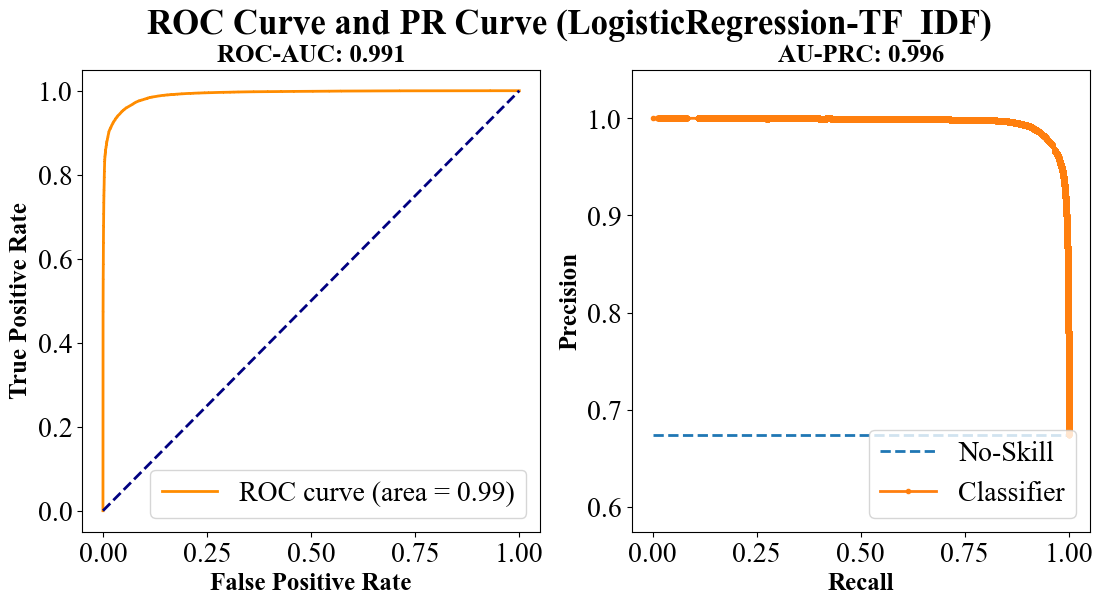

In [58]:
#====================================================================================================#
# TF-IDF Logistic Regression

estimator = LogisticRegression
param_grid = {'C': [0.1, 1, 10, 100],
              'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
LogReg_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator               ,
                    param_grid   =  param_grid              ,
                    n_jobs       =  -1                      , # Ensure all available processors are used.
                    cv           =  5                       ,
                    scoring      =  'f1_micro'              , # Use F1-score as metric.
                    savings      =  "GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  5000                    ,
                    X_train      =  X_train_tfidf_selected  ,
                    y_train      =  y_train                 ,
                    X_test       =  X_test_tfidf_selected   ,
                    y_test       =  y_test                  ,
                    )


Previous Grid Search Results found in Saving Files. Skip the Grid Searsh.
Model: LogisticRegression, vectorizer: BoW.
Optimized Params found by Grid Search:  {'C': 100, 'solver': 'lbfgs'}
accuracy_score  : 0.9545
precision_score : 0.9671
recall_score    : 0.9654
f1_score_score  : 0.9662
ROC_AUC         : 0.9486

Confusion Matrix
 [[33380  2441]
 [ 2573 71685]]


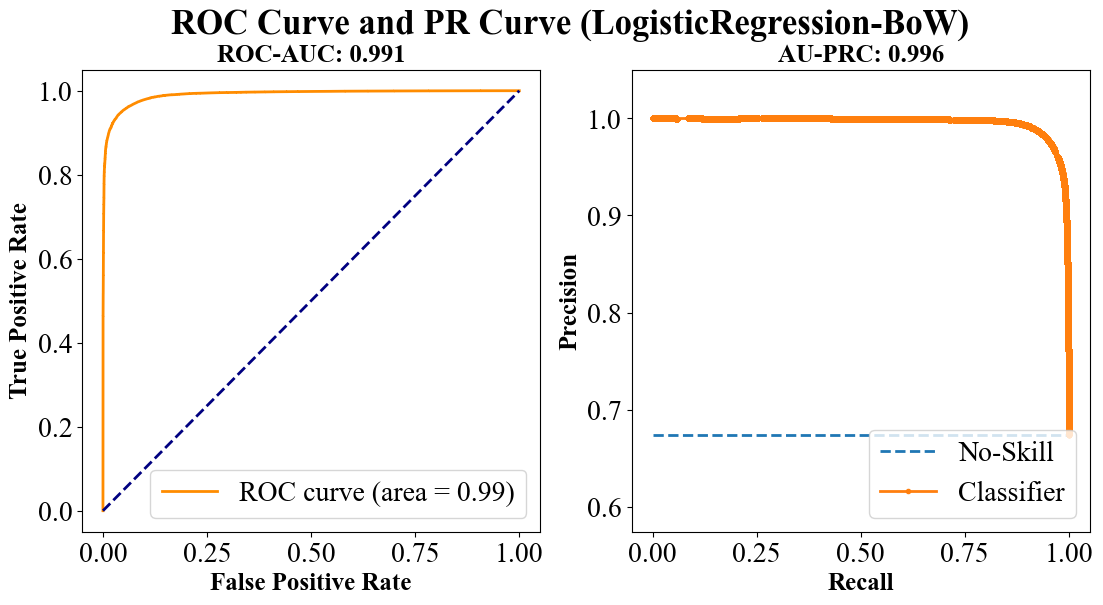

In [36]:
#====================================================================================================#
# Bag of Words Logistic Regression
lr_bow = LogisticRegression
param_grid = {'C': [0.1, 1, 10, 100],
              'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
LogReg_BoW_Accuracy, _ = \
GridSearchCV_expand(estimator    =  lr_bow                  ,
                    param_grid   =  param_grid              ,
                    n_jobs       =  -1                      , # Ensure all available processors are used.
                    cv           =  5                       ,
                    scoring      =  'f1_micro'              , # Use F1-score as metric.
                    savings      =  "GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "BoW"                   , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  5000                    ,
                    X_train      =  X_train_bow_selected    ,
                    y_train      =  y_train                 ,
                    X_test       =  X_test_bow_selected     ,
                    y_test       =  y_test                  ,
                    )

Previous Grid Search Results found in Saving Files. Skip the Grid Searsh.
Model: MultinomialNB, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'alpha': 0.1}
accuracy_score  : 0.9121
precision_score : 0.8953
recall_score    : 0.9849
f1_score_score  : 0.938
ROC_AUC         : 0.8731

Confusion Matrix
 [[27270  8551]
 [ 1120 73138]]


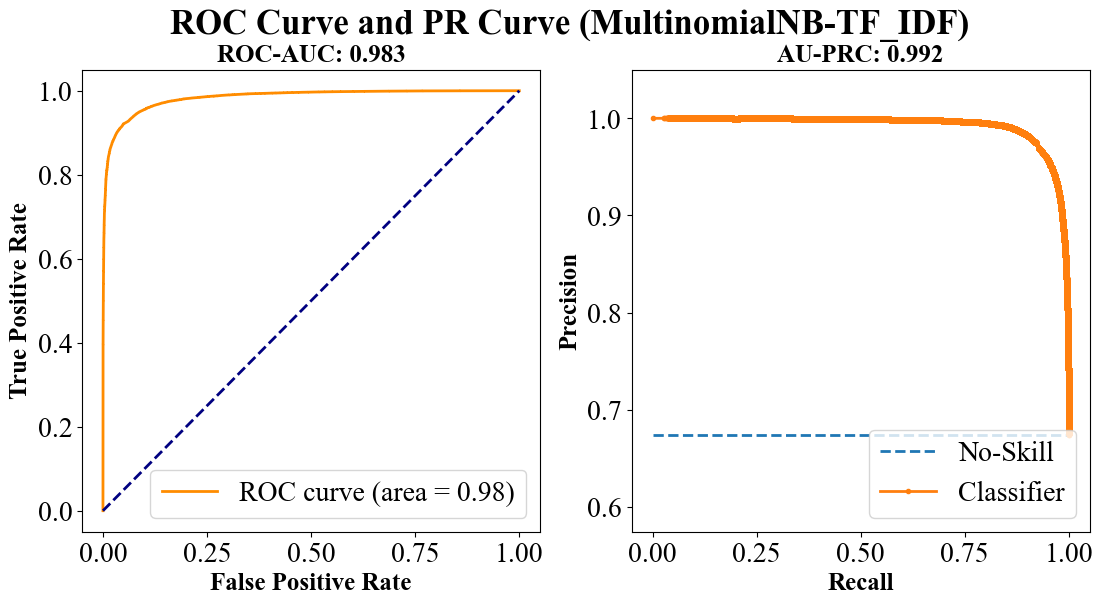

In [37]:
#====================================================================================================#
# TF-IDF Naive Bayes
estimator = MultinomialNB
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
NaiveBayes_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator               , 
                    param_grid   =  param_grid              , 
                    n_jobs       =  -1                      , # Ensure all available processors are used.
                    cv           =  5                       ,
                    scoring      =  'f1_micro'              , # Use F1-score as metric.
                    savings      =  "GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                    , 
                    X_train      =  X_train_tfidf_selected  , 
                    y_train      =  y_train                 , 
                    X_test       =  X_test_tfidf_selected   , 
                    y_test       =  y_test                  , 
                    )



Previous Grid Search Results found in Saving Files. Skip the Grid Searsh.
Model: MultinomialNB, vectorizer: BoW.
Optimized Params found by Grid Search:  {'alpha': 0.1}
accuracy_score  : 0.9392
precision_score : 0.9544
recall_score    : 0.9555
f1_score_score  : 0.9549
ROC_AUC         : 0.9304

Confusion Matrix
 [[32433  3388]
 [ 3308 70950]]


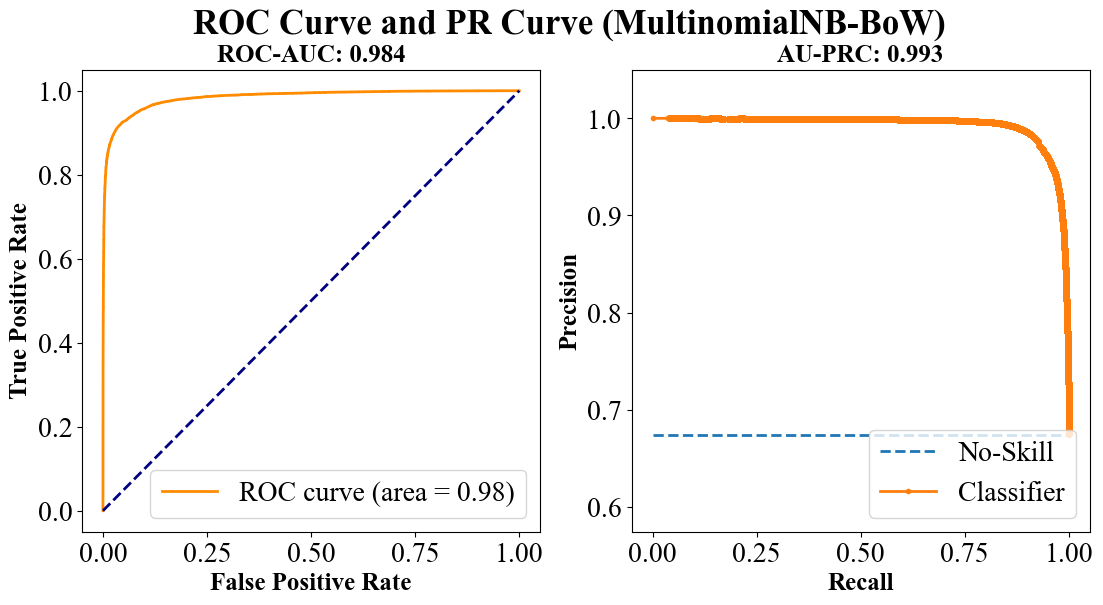

In [38]:
#====================================================================================================#
# Bag of Words Naive Bayes
estimator = MultinomialNB
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
NaiveBayes_BoW_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator               , 
                    param_grid   =  param_grid              , 
                    n_jobs       =  -1                      , # Ensure all available processors are used.
                    cv           =  5                       ,
                    scoring      =  'f1_micro'              , # Use F1-score as metric.
                    savings      =  "GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "BoW"                   , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                    , 
                    X_train      =  X_train_bow_selected    ,
                    y_train      =  y_train                 ,
                    X_test       =  X_test_bow_selected     ,
                    y_test       =  y_test                  ,
                    )


Previous Grid Search Results found in Saving Files. Skip the Grid Searsh.
Model: DecisionTreeClassifier, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2}
accuracy_score  : 0.8213
precision_score : 0.925
recall_score    : 0.7999
f1_score_score  : 0.8579
ROC_AUC         : 0.8327

Confusion Matrix
 [[31003  4818]
 [14857 59401]]


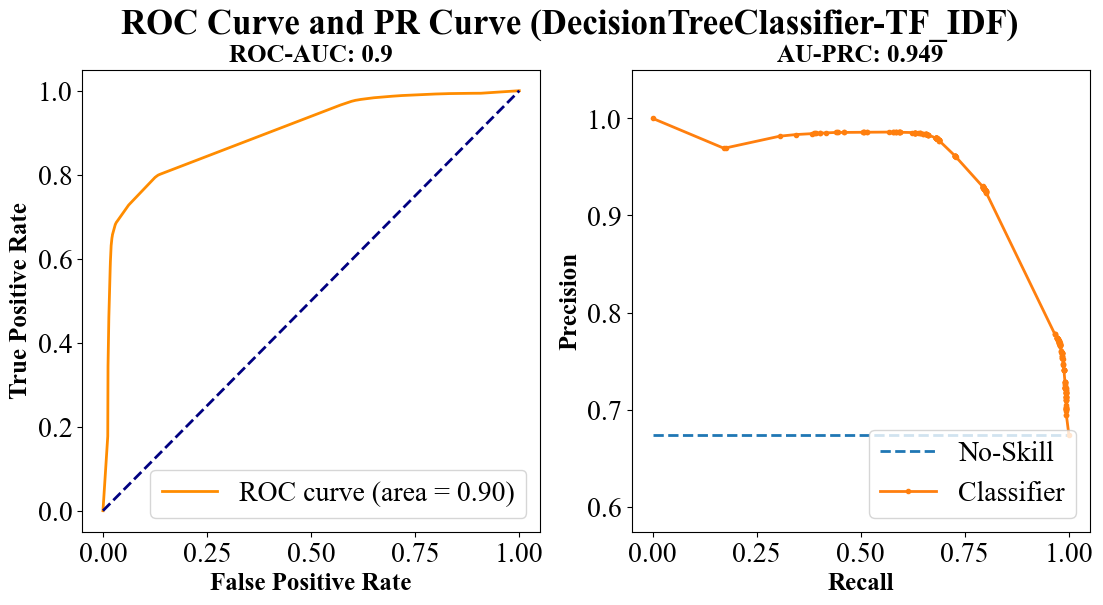

In [39]:
#====================================================================================================#
# TF-IDF Decision Tree
estimator = DecisionTreeClassifier
param_grid = {'max_features': ["sqrt", "log2"], 'max_depth': [10, 20, 50], 'min_samples_split': [2, 5, 10]}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
DT_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator               , 
                    param_grid   =  param_grid              , 
                    n_jobs       =  -1                      , # Ensure all available processors are used.
                    cv           =  5                       ,
                    scoring      =  'f1_micro'              , # Use F1-score as metric.
                    savings      =  "GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                    , 
                    X_train      =  X_train_tfidf_selected  , 
                    y_train      =  y_train                 , 
                    X_test       =  X_test_tfidf_selected   , 
                    y_test       =  y_test                  , 
                    )



Previous Grid Search Results found in Saving Files. Skip the Grid Searsh.
Model: DecisionTreeClassifier, vectorizer: BoW.
Optimized Params found by Grid Search:  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 5}
accuracy_score  : 0.8064
precision_score : 0.7927
recall_score    : 0.9656
f1_score_score  : 0.8706
ROC_AUC         : 0.721

Confusion Matrix
 [[17069 18752]
 [ 2556 71702]]


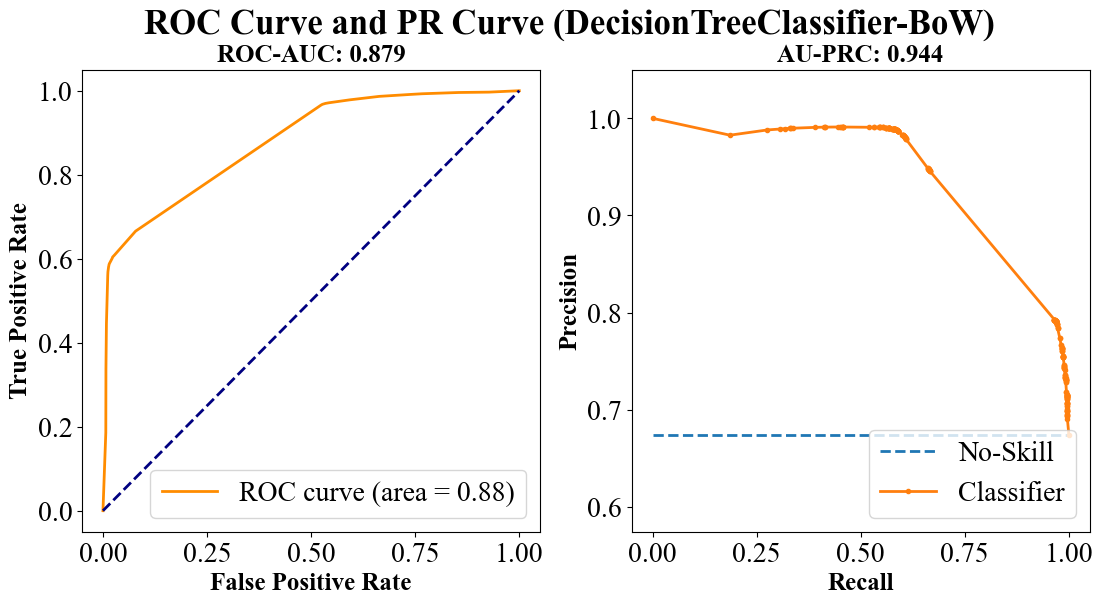

In [40]:
#====================================================================================================#
# Bag of Words Decision Tree
estimator = DecisionTreeClassifier
param_grid = {'max_features': ["sqrt", "log2"], 'max_depth': [10, 20, 50], 'min_samples_split': [2, 5, 10]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
DT_BoW_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator               , 
                    param_grid   =  param_grid              , 
                    n_jobs       =  -1                      , # Ensure all available processors are used.
                    cv           =  5                       ,
                    scoring      =  'f1_micro'              , # Use F1-score as metric.
                    savings      =  "GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "BoW"                   , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                    , 
                    X_train      =  X_train_bow_selected    ,
                    y_train      =  y_train                 ,
                    X_test       =  X_test_bow_selected     ,
                    y_test       =  y_test                  ,
                    )

Previous Grid Search Results found in Saving Files. Skip the Grid Searsh.
Model: XGBClassifier, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100}
accuracy_score  : 0.7466
precision_score : 0.8248
recall_score    : 0.7929
f1_score_score  : 0.8085
ROC_AUC         : 0.7218

Confusion Matrix
 [[23313 12508]
 [15382 58876]]


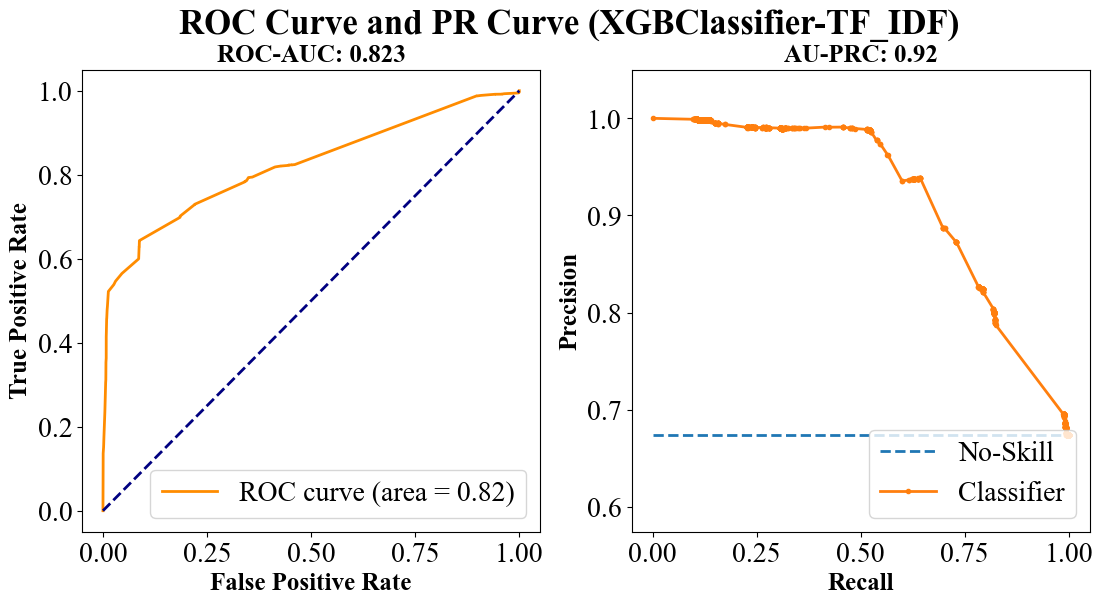

In [41]:
#====================================================================================================#
# TF-IDF XGBoost
estimator = XGBClassifier
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.5]}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
XGBoost_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                              , 
                    param_grid   =  param_grid                             , 
                    n_jobs       =  -1                                     , # Ensure all available processors are used.
                    cv           =  5                                      ,
                    scoring      =  'f1_micro'                             , # Use F1-score as metric.
                    savings      =  "GridSearchSavings.p"                  , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                               , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                   , 
                    X_train      =  X_train_tfidf_selected                 , 
                    y_train      =  y_train                                , 
                    X_test       =  X_test_tfidf_selected                  , 
                    y_test       =  y_test                                 , 
                    extra_params =  {"tree_method":'gpu_hist', "gpu_id":0} , 
                    )

Previous Grid Search Results found in Saving Files. Skip the Grid Searsh.
Model: XGBClassifier, vectorizer: BoW.
Optimized Params found by Grid Search:  {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 500}
accuracy_score  : 0.9587
precision_score : 0.9703
recall_score    : 0.9684
f1_score_score  : 0.9693
ROC_AUC         : 0.9534

Confusion Matrix
 [[33616  2205]
 [ 2343 71915]]


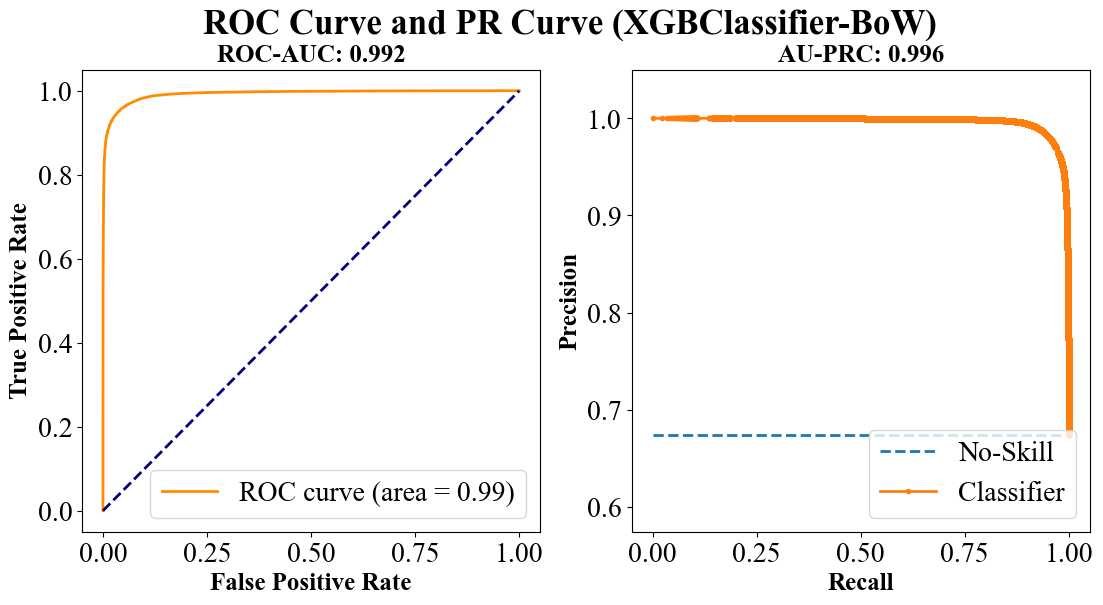

In [52]:
#====================================================================================================#
# Bag of Words XGBoost
estimator = XGBClassifier
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.5]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
XGBoost_BoW_Accuracy, GridSearch_results = \
GridSearchCV_expand(estimator    =  estimator                              , 
                    param_grid   =  param_grid                             , 
                    n_jobs       =  -1                                     , # Ensure all available processors are used.
                    cv           =  5                                      , 
                    scoring      =  'f1_micro'                             , # Use F1-score as metric.
                    savings      =  "GridSearchSavings.p"                  , # Save grid search results. 
                    vectorizer   =  "BoW"                                  , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                   , 
                    X_train      =  X_train_bow_selected                   , 
                    y_train      =  y_train                                , 
                    X_test       =  X_test_bow_selected                    , 
                    y_test       =  y_test                                 , 
                    extra_params =  {"tree_method":'gpu_hist', "gpu_id":0} , 
                    )

In [56]:
#====================================================================================================#
# 
print("Logistic Regression Accuracy - TF-IDF: {:.4f}, BoW: {:.4f}".format(LogReg_TFIDF_Accuracy      , LogReg_BoW_Accuracy      ))
print("Naive Bayes Accuracy         - TF-IDF: {:.4f}, BoW: {:.4f}".format(NaiveBayes_TFIDF_Accuracy  , NaiveBayes_BoW_Accuracy  ))
print("Decision Tree Accuracy       - TF-IDF: {:.4f}, BoW: {:.4f}".format(DT_TFIDF_Accuracy          , DT_BoW_Accuracy          ))
print("XGBoost Accuracy             - TF-IDF: {:.4f}, BoW: {:.4f}".format(XGBoost_TFIDF_Accuracy     , XGBoost_BoW_Accuracy     ))

optimized_params = GridSearch_results[("XGBClassifier", "BoW")]

print("\nSummary: XGBClassifier with Bag of Words has the best accuracy. ")
print(f"Grid Search has found best parameters for the model are, {optimized_params}")

Logistic Regression Accuracy - TF-IDF: 0.9557, BoW: 0.9545
Naive Bayes Accuracy         - TF-IDF: 0.9121, BoW: 0.9392
Decision Tree Accuracy       - TF-IDF: 0.8213, BoW: 0.8064
XGBoost Accuracy             - TF-IDF: 0.7466, BoW: 0.9587

Summary: XGBClassifier with Bag of Words has the best accuracy. 
Grid Search has found best parameters for the model are, {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 500}


In [57]:
XGBClassifier(learning_rate= 0.5, max_depth= 10, n_estimators= 500)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Part 2

### Get a Trained Sentiment Binary Classifier based on Analysis in Part 1
- Get the best-performed model from Part 1 (i.e., XGBClassifier).
- Prepare the data in the same way as Part 1 (Clean the Text).
- Apply the same feature selector and vectorizer as Part 1 (i.e., Chi2).
- Train the best-performed model with entire processed dataset (using BoW as Vectorizer).

In [61]:
#====================================================================================================#
# Get the best-performed model from Part 1
Sentiment_Binary_Classifier_Part1 = XGBClassifier(learning_rate = 0.5        , 
                                                  max_depth     = 10         , 
                                                  n_estimators  = 500        , 
                                                  random_state  = 1624       ,
                                                  tree_method   = 'gpu_hist' , 
                                                  gpu_id        = 0          ,
                                                  )

#====================================================================================================#
# Prepare the data. 
data_folder = Path("./data_folder")
data_file   = "sentiment_analysis.csv"
#--------------------------------------------------#
# Load data with "ISO-8859-1" encoding.
df_raw = pd.read_csv(filepath_or_buffer   =   data_folder/data_file             ,
                     header               =   0                                 , 
                     #index_col           =   0                                 ,
                     encoding             =   "ISO-8859-1"                      ,
                     sep                  =   ','                               ,  
                     low_memory           =   False                             , )
#--------------------------------------------------#
# Remove unicode characters from the string.
def remove_unicode(str_x):
    return str_x.encode("ascii", "ignore").decode()
#--------------------------------------------------#
# Remove all kinds of tags from the text data. 
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)                    # Remove HTML tags
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text)            # Remove user tags
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)           # Remove non-alphanumeric characters
    text = re.sub(r'#(\S+)', r'\1', text)                # Remove "#" in Hashtags.
    text = re.sub(r'^RT ', '', text)                     # Remove Retweet
    return remove_unicode(text.strip()).lower()
#--------------------------------------------------#
# processed the entire dataset. 
df_cleaned = copy.deepcopy(df_raw)
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(clean_text)
df_cleaned = df_cleaned.drop(columns=["ID", "text"])
df_cleaned.insert(len(df_cleaned.columns)-1, "label", df_cleaned.pop('label') ) 
df = copy.deepcopy(df_cleaned) ; del df_cleaned ; del df_raw
#--------------------------------------------------#
# Split the dataset. (Optional)
X_data = df['cleaned_text'].values.tolist()
y_data = df['label']       .values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 1624)

#====================================================================================================#
# Prepare Machine Learning-Ready Dataset. 
# Vectorizer - Bag of Words.
vectorizer = CountVectorizer()
X_data_bow = vectorizer.fit_transform(X_data)
#--------------------------------------------------#
# Select feature using the same selector in Part 1. 
selector = SelectKBest(chi2, k = 1000)
X_data_bow_selected = selector.fit_transform(X_data_bow, y_data)

#====================================================================================================#
# Use the entire dataset to train the best model we have from Part 1. 
Sentiment_Binary_Classifier_Part1.fit(X_train_bow_selected,y_train) 

print("Sentiment_Binary_Classifier_Part1 is Trained on the entire sentiment analysis dataset. ")



Sentiment_Binary_Classifier_Part1 is Trained on the entire sentiment analysis dataset. 


### Get Pretrained model- Vader

In [ ]:
# Apply a pretrained model Vader and compute a threshold
def pre_label(df, column):
    df1=df.copy(deep=True)
    model = SentimentIntensityAnalyzer()
    df_pred = [*df1[column].apply(model.polarity_scores)]
    neglst = []
    neulst = []
    poslst = []
    compoundlst = []
    for i in df_pred:
        neglst.append(i['neg'])
        poslst.append(i['pos'])
        neulst.append(i['neu'])
        compoundlst.append(i['compound'])
    dfpred = pd.DataFrame({'neg':neglst, 'pos':poslst,'neu': neulst, 'compound': compoundlst})
    df1['compound'] = dfpred['compound'].tolist()
    df1 = df1.dropna()
    threshold = df1['compound'].mean()
    print(threshold)
     # compute y-labels using pretrain model
    df1['label'] = 0
    df1.loc[df1['compound'] >= threshold, 'label'] = 1
    return df1

In [123]:
# Apply a pretrained model Vader and compute a threshold
def pre_label(df, column):
    df1=df.copy(deep=True)
    model = SentimentIntensityAnalyzer()
    df_pred = [*df1[column].apply(model.polarity_scores)]
    neglst = []
    neulst = []
    poslst = []
    compoundlst = []
    for i in df_pred:
        neglst.append(i['neg'])
        poslst.append(i['pos'])
        neulst.append(i['neu'])
        compoundlst.append(i['compound'])
    dfpred = pd.DataFrame({'neg':neglst, 'pos':poslst,'neu': neulst, 'compound': compoundlst})
    df1['compound'] = dfpred['compound'].tolist()
    df1 = df1.dropna()
    threshold = df1['compound'].mean()
    print(threshold)
     # compute y-labels using pretrain model
    df1['label'] = 0
    df1.loc[df1['compound'] >= threshold, 'label'] = 1
    return df1

## New dataset 1-reddit_raw_ukraine_russia.csv

### Data cleaning

In [124]:
# check the string is english or not
def is_english_only_string(s):
    return not bool(re.search('[^\x00-\x7F]+', s))

In [125]:
newdata1 = pd.read_csv('/content/gdrive/MyDrive/reddit_raw_ukraine_russia.csv')
newdata1 = newdata1['comments'].dropna() # drop none value in newdata set
newdata1_all = newdata1.copy(deep=True)
newdata1_all = pd.DataFrame(newdata1_all) # create a new dataframe contains all languages
newdata1_eng = newdata1_all[newdata1_all.comments.map(lambda x:is_english_only_string(x))] # filter the english strings

In [126]:
newdata1_all['cleaned_text'] = newdata1_all['comments'].apply(clean_text)
newdata1_eng['cleaned_text'] = newdata1_eng['comments'].apply(clean_text)

In [127]:
newdata1

0        Hello /u/hjgbuijhgh,\n\nThis community is focu...
1        uhm thats quite the increase.  \n\n\nI also he...
2        Poland also announced that they plan to double...
3        Remember, NATO knows more than we’re being tol...
4        Well done, Putin. Top 2022 salesman of NATO. \...
                               ...                        
16702    not the region where you wanna practice Russia...
16703    Only Estonia is far from the USA. If in the US...
16704    The Russians can jump through the hoops to acq...
16705    At this point Russia will invade anyone it wan...
16706    *"Estonian and Ukrainian languages are bold an...
Name: comments, Length: 16707, dtype: object

### Prediction

In [128]:
#Vader--English comments
df,column = newdata1_eng, 'comments'
dfnew1_eng = pre_label(df,column)

dfnew1_eng_c = dfnew1_eng['comments'] # select the column 'comments' of new dataset1(English)
# Bag of Words--English comments
dfnew1_eng_c = vectorizer.transform(dfnew1_eng_c)
dfnew1_eng_c = selector.transform(dfnew1_eng_c)

pred1_eng = xgbbest.predict(dfnew1_eng_c) # return y prediction values of new dataset1(English)

-0.06999917588375625


In [129]:
#Vader--English comments
df,column = newdata1_all, 'comments'
dfnew1_all = pre_label(df,column)
dfnew1_all_c = dfnew1_all['comments'] # select the column 'comments' of new dataset1 (all languages)

# Bag of Words--All comments
dfnew1_all_c = vectorizer.transform(dfnew1_all_c)
dfnew1_all_c = selector.transform(dfnew1_all_c)

pred1_all = xgbbest.predict(dfnew1_all_c) # return y prediction values of new dataset1(all languages)

-0.07447011432333753


In [130]:
# compute accuracy between pretrained model and xgboost model
allv = dfnew1_all['label'].tolist()
allxb = pred1_all.tolist()
engv = dfnew1_eng['label'].tolist()
engxb = pred1_eng.tolist()
print('All language accuracy: {} \nEnglish only accuracy: {}'.format(accuracy_score(allv, allxb),accuracy_score(engv, engxb)))

All language accuracy: 0.5954988926797151 
English only accuracy: 0.5893876960890624


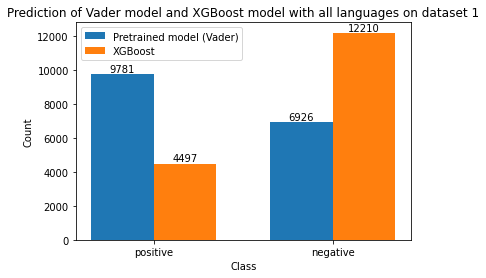

In [131]:
import matplotlib.pyplot as plt

labels = ['positive', 'negative']
values1 = [len([x for x in allv if x == 1]), 
           len([x for x in allv if x == 0])]
values2 = [len([x for x in allxb if x == 1]),
           len([x for x in allxb if x == 0])]

# Set the width of each bar
width = 0.35

# Create a bar plot for values1
p1 = plt.bar(labels, values1, width, label='Pretrained model (Vader)')

# Create a bar plot for values2
p2 = plt.bar([i + width for i in range(len(values2))], values2, width, label='XGBoost')
plt.bar_label(p1)
plt.bar_label(p2)
# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Prediction of Vader model and XGBoost model with all languages on dataset 1')
plt.xticks(np.arange(2)+0.175,labels)
# Add a legend
plt.legend()

# Show the plot
plt.show()


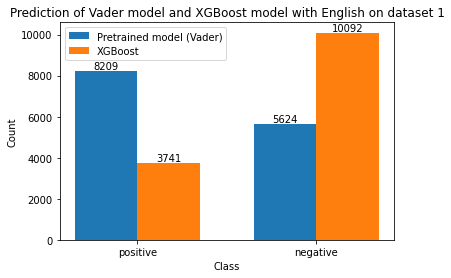

In [132]:
labels = ['positive', 'negative']
values3 = [len([x for x in engv if x == 1]), 
           len([x for x in engv if x == 0])]
values4 = [len([x for x in engxb if x == 1]),
           len([x for x in engxb if x == 0])]

# Set the width of each bar
width = 0.35

# Create a bar plot for values1
p3 = plt.bar(labels, values3, width, label='Pretrained model (Vader)')

# Create a bar plot for values2
p4 = plt.bar([i + width for i in range(len(values4))], values4, width, label='XGBoost')
plt.bar_label(p3)
plt.bar_label(p4)
# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Prediction of Vader model and XGBoost model with English on dataset 1')
plt.xticks(np.arange(2)+0.175,labels)
# Add a legend
plt.legend()

# Show the plot
plt.show()

## New dataset 2 -russian_invasion_of_ukraine.csv

In [133]:
file_2='/content/gdrive/MyDrive/russian_invasion_of_ukraine.csv'

df_inv_tmp=pd.read_csv(file_2, header=[0])

In [134]:
df_inv_tmp.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Live updates: Russians destroy Chernobyl labor...,56,tkjwjl,https://www.washingtonpost.com/politics/live-u...,15.0,1.648003e+09,NaN,2022-03-23 02:34:15
1,Romania Is Handing Out 30 Million Anti-Radiati...,265,tkjqga,https://www.vice.com/amp/en/article/pkpw7b/iod...,22.0,1.648002e+09,NaN,2022-03-23 02:25:07
2,Oil rises towards $116 as EU weighs Russian ban,28,tk1utj,https://www.reuters.com/business/energy/oil-op...,2.0,1.647952e+09,NaN,2022-03-22 12:27:29
3,Russia Sends $66 Million Coupon to Depository ...,44,tk1nlm,https://www.bloomberg.com/news/articles/2022-0...,8.0,1.647951e+09,NaN,2022-03-22 12:17:29
4,Ukraine war latest: Global diesel shortage loo...,31,tk1ky3,https://www.ft.com/content/795b432f-b189-4c91-...,3.0,1.647951e+09,NaN,2022-03-22 12:13:26


In [135]:
#Keep the comments part
df_inv=df_inv_tmp[['body']].dropna()
#Convert the datatype to String
df_inv['body'] = df_inv['body'].astype(str)
#Apply the text cleaning function
df_inv['cleaned_text'] = df_inv['body'].apply(clean_text)

In [136]:
df_inv

,body,cleaned_text
9,"What if I told you, barbarians already, this e...",what if i told you barbarians already this eve...
10,Oh no. Decathlon is bad? I just ordered from t...,oh no decathlon is bad i just ordered from them
11,Last I read they have commited almost all thei...,last i read they have commited almost all thei...
12,Lukashenko was already president…. The protest...,lukashenko was already president the protests ...
13,Russia: 🥺,russia
...,...,...
253489,I doubt the city being a major city will put a...,i doubt the city being a major city will put a...
253490,Except China isn’t just any country. They have...,except china isnt just any country they have t...
253491,As they weren’t shitting themselves before…,as they werent shitting themselves before
253492,"TL:\n\nIn Mariupol, which was temporarily capt...",tlin mariupol which was temporarily captured b...


In [137]:
#Check language
df_inv_eng = df_inv['cleaned_text'][df_inv['cleaned_text'].map(lambda x:is_english_only_string(x))]

In [138]:
#Check if there are other languages, if True, the comments text all considered English
print(df_inv_eng.shape[0]==df_inv.shape[0])

True


### Prediction

In [139]:
# XGBoost with Bag of Words
df_inv_bow = vectorizer.transform(df_inv['cleaned_text'])
df_inv_bow_selected = selector.transform(df_inv_bow)
#Predict labels using the best model
df_inv_bow_xgbpred=xgbbest.predict(df_inv_bow_selected)

In [140]:
df_inv_bow_xgbpred_tmp=pd.DataFrame(df_inv_bow_xgbpred.astype(int),index=df_inv.index,columns=['label'])
df_inv_bow_xgbpred=pd.concat([df_inv,df_inv_bow_xgbpred_tmp],axis=1)

In [141]:
df_inv_bow_xgbpred

,body,cleaned_text,label
9,"What if I told you, barbarians already, this e...",what if i told you barbarians already this eve...,0
10,Oh no. Decathlon is bad? I just ordered from t...,oh no decathlon is bad i just ordered from them,0
11,Last I read they have commited almost all thei...,last i read they have commited almost all thei...,0
12,Lukashenko was already president…. The protest...,lukashenko was already president the protests ...,0
13,Russia: 🥺,russia,0
...,...,...,...
253489,I doubt the city being a major city will put a...,i doubt the city being a major city will put a...,0
253490,Except China isn’t just any country. They have...,except china isnt just any country they have t...,0
253491,As they weren’t shitting themselves before…,as they werent shitting themselves before,0
253492,"TL:\n\nIn Mariupol, which was temporarily capt...",tlin mariupol which was temporarily captured b...,1


In [142]:
# Vader
df_inv_vaderpred=pre_label(df_inv,"cleaned_text")

-0.05395636888298671


In [143]:
df_inv_vaderpred

,body,cleaned_text,compound,label
9,"What if I told you, barbarians already, this e...",what if i told you barbarians already this eve...,0.0000,1
10,Oh no. Decathlon is bad? I just ordered from t...,oh no decathlon is bad i just ordered from them,-0.6908,0
11,Last I read they have commited almost all thei...,last i read they have commited almost all thei...,-0.2815,0
12,Lukashenko was already president…. The protest...,lukashenko was already president the protests ...,-0.5568,0
13,Russia: 🥺,russia,0.0000,1
...,...,...,...,...
253489,I doubt the city being a major city will put a...,i doubt the city being a major city will put a...,-0.4854,0
253490,Except China isn’t just any country. They have...,except china isnt just any country they have t...,-0.2732,0
253491,As they weren’t shitting themselves before…,as they werent shitting themselves before,0.3252,1
253492,"TL:\n\nIn Mariupol, which was temporarily capt...",tlin mariupol which was temporarily captured b...,0.9338,1


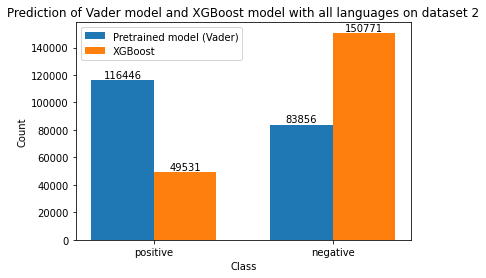

In [144]:
labels = ['positive', 'negative']
values1 = [len([x for x in df_inv_vaderpred['label'] if x == 1]), 
           len([x for x in df_inv_vaderpred['label'] if x == 0])]
values2 = [len([x for x in df_inv_bow_xgbpred['label'] if x == 1]),
           len([x for x in df_inv_bow_xgbpred['label'] if x == 0])]

# Set the width of each bar
width = 0.35

# Create a bar plot for values1
p1 = plt.bar(labels, values1, width, label='Pretrained model (Vader)')

# Create a bar plot for values2
p2 = plt.bar([i + width for i in range(len(values2))], values2, width, label='XGBoost')
plt.bar_label(p1)
plt.bar_label(p2)
# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Prediction of Vader model and XGBoost model with all languages on dataset 2')
plt.xticks(np.arange(2)+0.175,labels)
# Add a legend
plt.legend()

# Show the plot
plt.show()
